In [ ]:
pip install torch torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

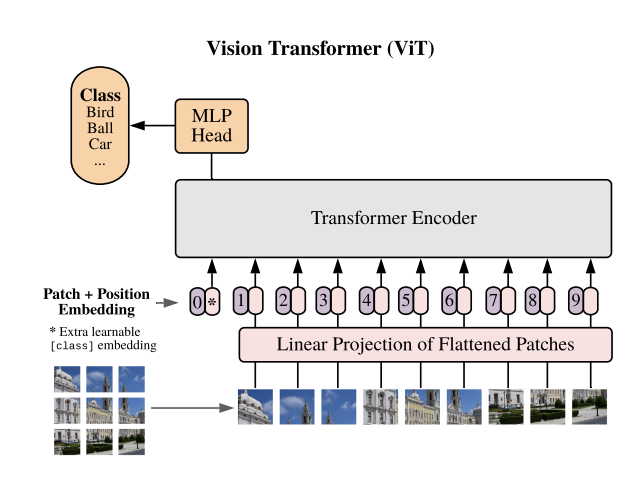

###1. Patch Embeddings

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (batch_size, embed_dim, num_patches^(1/2), num_patches^(1/2))
        x = x.flatten(2)  # (batch_size, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (batch_size, num_patches, embed_dim)
        return x

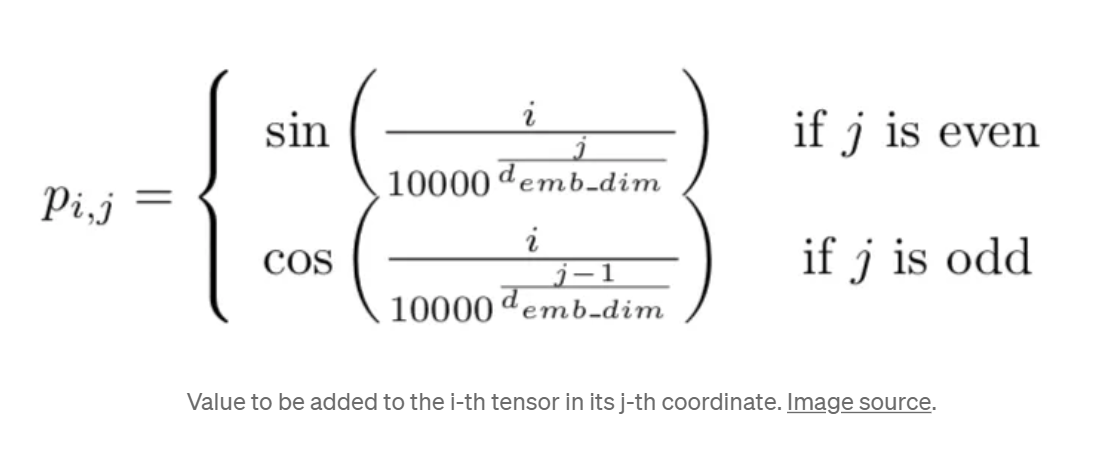
### 2. Positional Embeddings

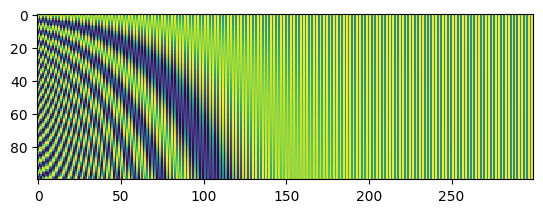

In [ ]:
def get_positional_embeddings(num_patches, embed_dim):
    result = torch.ones(num_patches, embed_dim)
    for i in range(num_patches):
        for j in range(embed_dim):
            result[i][j] = np.sin(i / (10000 ** (j / embed_dim))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / embed_dim)))
    return result

if __name__ == "__main__":
  import matplotlib.pyplot as plt

  plt.imshow(get_positional_embeddings(100, 300), interpolation="nearest")
  plt.show()

### 3. Attention



In [ ]:
class Attention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5  # Scaling factor for dot product attention

        # Linear layers to project the input embeddings to queries, keys, and values
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.fc = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, N, E = x.shape

        Q = self.q_proj(x)  # (B, N, E)
        K = self.k_proj(x)
        V = self.v_proj(x)

        # Split Q, K, V for multi-head attention and scale Q
        Q = Q.view(B, N, self.num_heads, self.head_dim).transpose(1, 2)  # (B, num_heads, N, head_dim)
        K = K.view(B, N, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(B, N, self.num_heads, self.head_dim).transpose(1, 2)

        Q = Q * self.scale  # Scale queries

        attn_scores = torch.matmul(Q, K.transpose(-2, -1))

        # Apply softmax to get attention weights
        attn_weights = torch.softmax(attn_scores, dim=-1)

        # Compute the attention output
        attn_output = torch.matmul(attn_weights, V)  # (B, num_heads, N, head_dim)

        # Concatenate heads and apply the final linear layer
        attn_output = attn_output.transpose(1, 2).view(B, N, E)
        output = self.fc(attn_output)  # (B, N, E)

        return output

# Example usage:
embed_dim = 128
num_heads = 8
x = torch.randn(32, 10, embed_dim)  # Example input: (batch_size, sequence_length, embedding_dim)
attention_layer = Attention(embed_dim, num_heads)
output = attention_layer(x)
print(output.shape)

torch.Size([32, 10, 128])


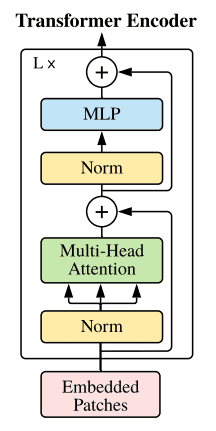

### 4. MLP (Multi-Layer Perception)
Feed Forward Network

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, embed_dim, hidden_dim, dropout=0.1):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### 5. Transformer Encoder Layers

In [ ]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.attn = Attention(embed_dim, num_heads)
        self.hidden = FeedForward(embed_dim, hidden_dim, dropout)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        # Multi-head attention & skip connection
        attn_output = self.attn(self.norm1(x))
        x = x + self.dropout1(attn_output)

        # MLP with skip connection
        hidden_output = self.hidden(self.norm2(x))
        x = x + self.dropout2(hidden_output)

        return x

### 6. Transformer Encoder

In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim, num_layers, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(embed_dim, num_heads, hidden_dim, dropout) for _ in range(num_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [ ]:
encoder = TransformerEncoder(embed_dim = 128, num_heads = 8, hidden_dim = 32, num_layers = 4, dropout = 0.1)
x = torch.randn(32, 16, embed_dim)
output = encoder(x)
print(output.shape)

torch.Size([32, 16, 128])


### 7. Vision Transformer

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, num_classes, embed_dim, num_heads, hidden_dim, num_layers, dropout=0.1):
        super(VisionTransformer, self).__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim)) #CLS token
        self.pos_embed = nn.Parameter(get_positional_embeddings((img_size // patch_size) ** 2 + 1, embed_dim))
        self.dropout = nn.Dropout(dropout)
        self.encoder = TransformerEncoder(embed_dim, num_heads, hidden_dim, num_layers, dropout )
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, x):
        B = x.shape[0] #num of images in a batch
        x = self.patch_embed(x) # (B, num_patches + 1, embed_dim)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.dropout(x)
        x = self.encoder(x) # output x = (B , num_patches + 1, new_embed_dim)
        cls_output = x[:, 0] # class token from the encoded x
        output = self.mlp_head(cls_output)
        return output


In [ ]:
img_size = 32
patch_size = 4
in_channels = 3
num_classes = 10
embed_dim = 128
num_heads = 4
hidden_dim = 32
num_layers = 4
dropout = 0.1

vit = VisionTransformer(img_size, patch_size, in_channels, num_classes, embed_dim, num_heads, hidden_dim, num_layers, dropout)
x = torch.randn(32, 3, 32, 32)  # (batch_size, channels, height, width)
output = vit(x)
print(output.shape)  # (Batch_size , num_classes)


torch.Size([32, 10])


In [ ]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:18<00:00, 9279141.29it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


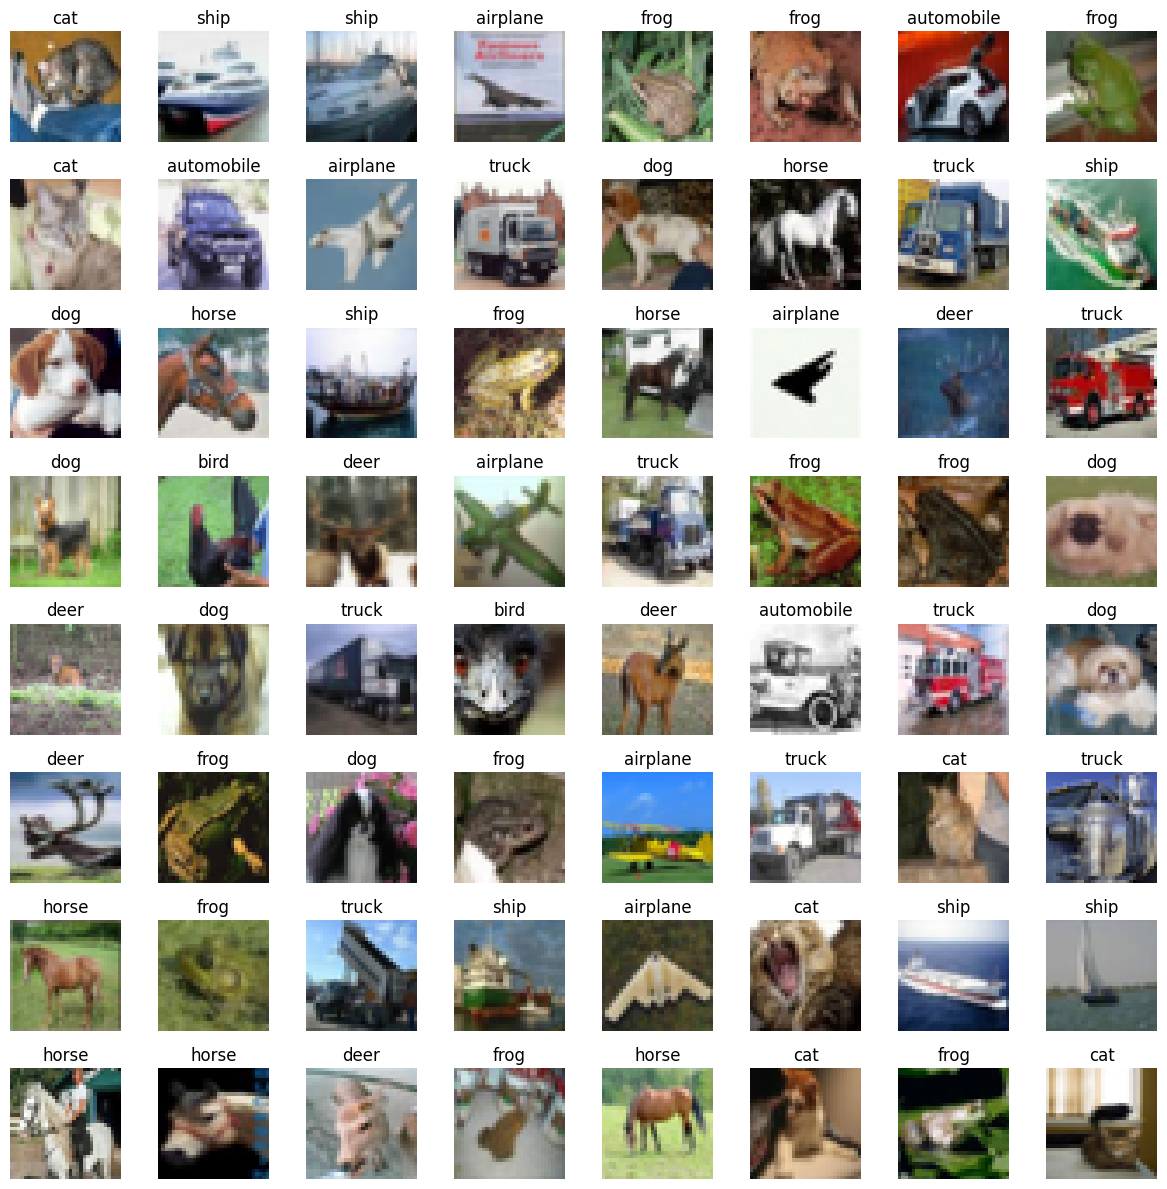

In [ ]:
# Function to display images with labels in a grid
def imshow_grid(images, labels):
    fig, axs = plt.subplots(8, 8, figsize=(12, 12))  # Create a figure and axes
    axs = axs.flatten()  # Flatten axes for easy iteration

    for i in range(64):
        img = images[i] / 2 + 0.5  # Unnormalize the image
        img = img.numpy()  # Convert image to numpy array
        img = np.transpose(img, (1, 2, 0))  # Transpose dimensions for correct display
        axs[i].imshow(img)  # Display the image
        axs[i].set_title(test_dataset.classes[labels[i]])  # Set title as class label
        axs[i].axis('off')  # Turn off axis

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()  # Show the plot

# Get a batch of 64 test images and labels
images, labels = next(iter(test_loader))

# Show images with labels in an 8x8 grid
imshow_grid(images, labels)

In [ ]:
model = VisionTransformer(
    img_size=32,
    patch_size=4,
    in_channels=3,
    num_classes=10,
    embed_dim=128,
    num_heads=4,
    hidden_dim=32,
    num_layers=4,
    dropout=0.1
)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(train_loader, 1):
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f'Accuracy on the test set: {(100 * correct / total):.2f}%')


Epoch [1/10], Loss: 1.6543
Epoch [2/10], Loss: 1.3936
Epoch [3/10], Loss: 1.2968
Epoch [4/10], Loss: 1.2292
Epoch [5/10], Loss: 1.1738
Epoch [6/10], Loss: 1.1298
Epoch [7/10], Loss: 1.0975
Epoch [8/10], Loss: 1.0600
Epoch [9/10], Loss: 1.0349
Epoch [10/10], Loss: 1.0041
Accuracy on the test set: 62.43%


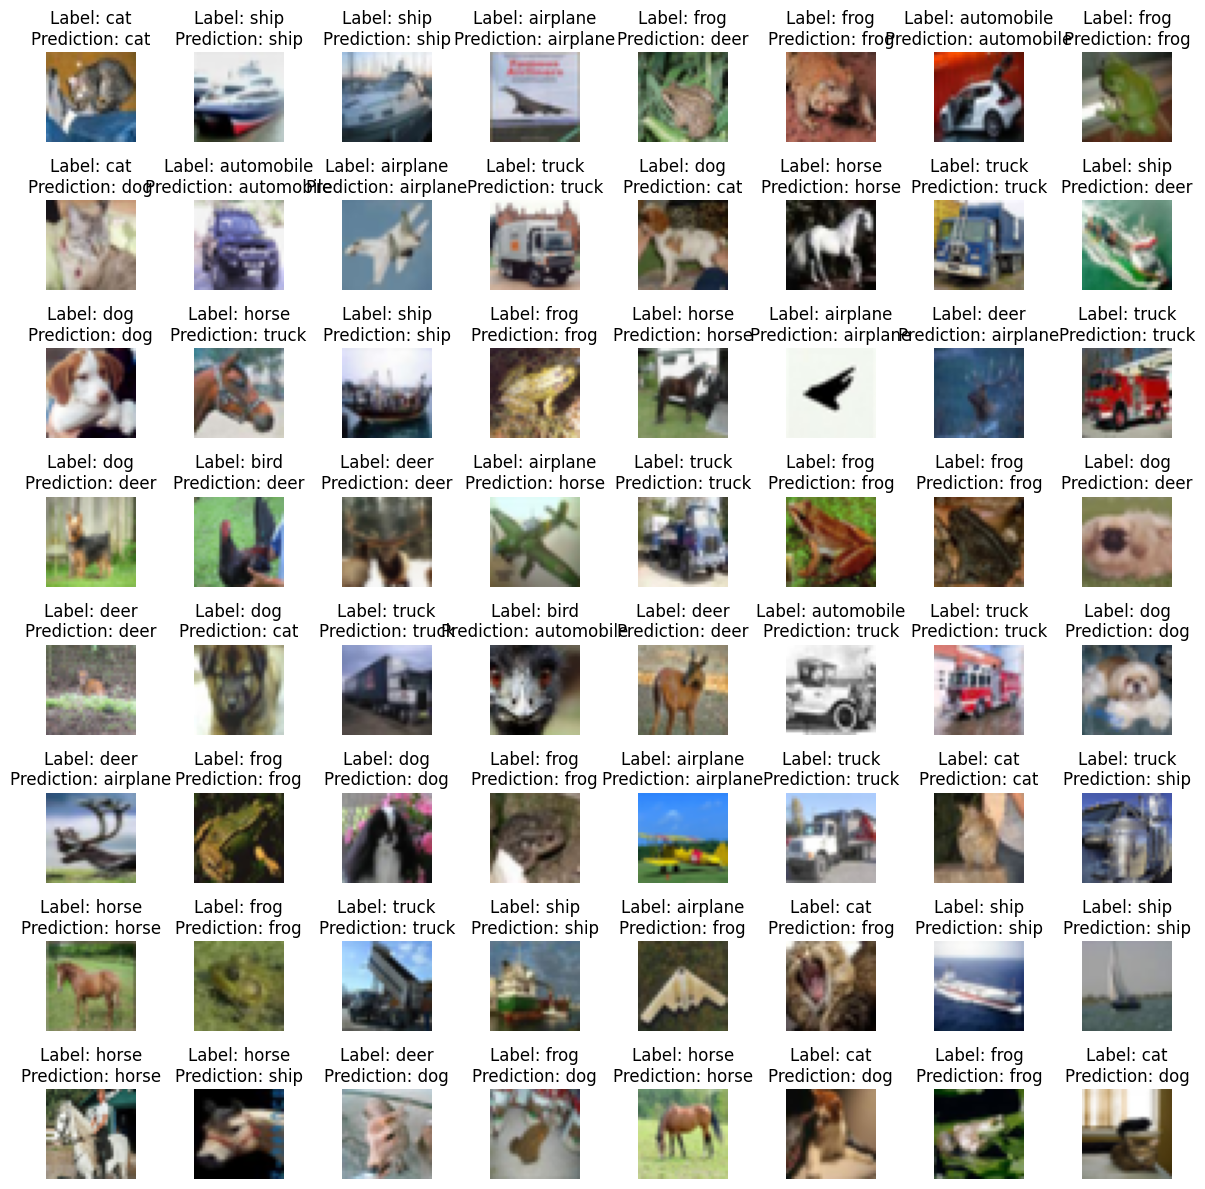

In [ ]:
def imshow_grid(images, labels, predicted_labels):
    fig, axs = plt.subplots(8, 8, figsize=(12, 12))
    axs = axs.flatten()

    for i in range(64):
        img = images[i] / 2 + 0.5
        img = img.numpy()
        img = np.transpose(img, (1, 2, 0))
        axs[i].imshow(img)
        axs[i].set_title(f'Label: {test_dataset.classes[labels[i]]}\nPrediction: {test_dataset.classes[predicted_labels[i]]}')
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

images, labels = next(iter(test_loader))

model.eval()
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

imshow_grid(images, labels, predicted)